In [186]:

%load_ext autoreload
%autoreload 2

import sys
import os
import json
import pandas as pd
import MDAnalysis as mda
from utils import utils
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sbmlcore
import random
from sklearn.utils import resample
from sklearn.tree import  plot_tree
from sklearn.metrics import roc_auc_score, confusion_matrix


import gumpy

from scipy.stats import sem


from scipy.stats import ttest_ind

from PIL import Image

sys.path.append(os.path.abspath('ml-models'))
from mlmodels.Models import Models

from sklearn.metrics import confusion_matrix


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset import

Data tables were generated in `methods.ipynb`.

In [76]:
#this contains all observed solos with phenotypes - helpful for reference, but not used for ML training/validation
all_solos = pd.read_csv('data/tables/generated/rpoB_solos.csv', index_col=0)

In [77]:
#this consitutes the ML training and validation data
data = pd.read_csv('data/tables/generated/features_dataset.csv', index_col=0)
#split into static features and those extracted from md 
dynamic_features = data[[col for col in data.columns if 'min' in col or 'mean' in col]]
data = data.drop(columns=[col for col in data.columns if 'min' in col or 'mean' in col])
data

,segid,resid,mutation,phenotype,d_volume,d_hydropathy_KD,d_MW,d_pi,d_rogov,Rif_distance,...,phi,psi,n_hbond_acceptors,n_hbond_donors,SASA,snap2_score,deep_ddG,rasp_score,temp_factor,secondary_structure
2,C,639,E639D,0,-27.3,0.0,-14.0,-0.45,0.109,34.015193,...,-72.58,-54.68,0.0,0.0,107.910414,50,-0.152,0.254674,41.400002,0
3,C,113,V113I,0,26.7,0.3,14.1,0.06,0.494,24.626817,...,-55.57,-55.02,2.0,0.0,46.996241,-95,0.471,0.222572,36.919998,1
4,C,642,G642S,0,28.9,-0.4,30.0,-0.29,0.120,42.448172,...,169.90,-149.75,1.0,1.0,0.226439,48,-2.495,0.548394,32.490002,2
5,C,751,I751V,0,-26.7,-0.3,-14.1,-0.06,0.494,27.986912,...,-161.65,154.98,1.0,1.0,23.895392,-91,-0.242,0.287591,19.900000,2
6,C,944,K944N,0,-54.5,0.4,-14.1,-4.33,0.197,59.941562,...,60.77,28.12,0.0,0.0,208.845293,-73,0.025,0.215516,86.489998,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,C,445,H445F,1,36.7,6.0,10.0,-2.11,-0.016,9.683248,...,-66.73,-38.07,1.0,2.0,6.609119,92,-0.684,0.201490,16.459999,1
263,C,434,M434I,1,3.8,2.6,-18.0,0.28,-0.452,9.843524,...,-62.15,126.41,0.0,1.0,7.242104,93,-1.393,0.290369,17.299999,3
264,C,262,V262A,1,-51.4,-2.4,-28.0,0.04,0.232,56.595298,...,-126.69,153.98,0.0,0.0,95.032454,-82,-0.214,0.275822,133.350006,3
265,C,582,S582A,1,-0.4,2.6,-16.0,0.32,0.249,18.638826,...,-95.24,-170.26,1.0,0.0,0.000000,29,-1.548,0.237018,18.350000,0


# RAVs are limited in number

Our dataset is very unbalanced, with the vast majority of mutations observed in susceptible samples only:


In [78]:
print ('number of resistant and susceptible mutations:', data.phenotype.value_counts())

number of resistant and susceptible mutations: phenotype
0    219
1     46
Name: count, dtype: int64


This will cause problems when both training and validating the model.

Firstly, susceptibility will be overrepresented, potentially requiring us to upsample the minority class.

Additionally, the model will become biased toward predicting susceptibility, leading to higher variance in predictions for resistant variants. The model may also overfit to the few resistant examples it sees.

It will be challenging to calibrate parameters for the model, as different data splits will result in varying predicted probability distributions.

Finally, with only about eight resistant variants in the validation set, any mutations incorrectly classified as resistant, or any phenotypes inaccurately predicted by the model, will significantly impact model performance, making it difficult to accurately evaluate the model.

Due to the variability in learning depending on the composition of each specific training/test split, we will use repeated Monte Carlo cross-validation (basically just lots of random train:test splits) instead of training a single model and validating on a single validation set. This approach will provide measures of error and variability in our performance evaluations, resulting in more accurate and honest reporting.

# RAVs are localised around the rif binding site - RRDR

#### Inside the RRDR

In [79]:
print ('number of resistant mutations in the RRDR:', len(data[(data.resid>=426)&(data.resid<=452)&(data.phenotype==1)]))
print ('number of susceptible mutations in the RRDR:', len(data[(data.resid>=426)&(data.resid<=452)&(data.phenotype==0)]))

number of resistant mutations in the RRDR: 36
number of susceptible mutations in the RRDR: 13


### Outside the RRDR

In [265]:
print('Number of resistant mutations outside the RRDR:', len(data[((data.resid < 426) | (data.resid > 452)) & (data.phenotype == 1)]))
print('Number of susceptible mutations outside the RRDR:', len(data[((data.resid < 426) | (data.resid > 452)) & (data.phenotype == 0)]))

Number of resistant mutations outside the RRDR: 10
Number of susceptible mutations outside the RRDR: 206


### Map onto RpoB structure 

In [260]:
all_solos.rename(columns={'MUTATION':'mutation'}, inplace=True)
utils.map_mut2pdb(pd.merge(data, all_solos, how='left', on=['mutation', 'segid']), './data/pdb/5uh6.pdb', './data/pdb/RpoB_mutations.pdb', phenotypes=True)

/Users/dylanadlard/miniforge3/envs/rif_manuscript/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
/Users/dylanadlard/miniforge3/envs/rif_manuscript/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


------------------------

Placeholder for figure 1

------------------------

The majority of resistance-associated variants are clustered within 12 Ångströms of rifampicin in the crystal structure:

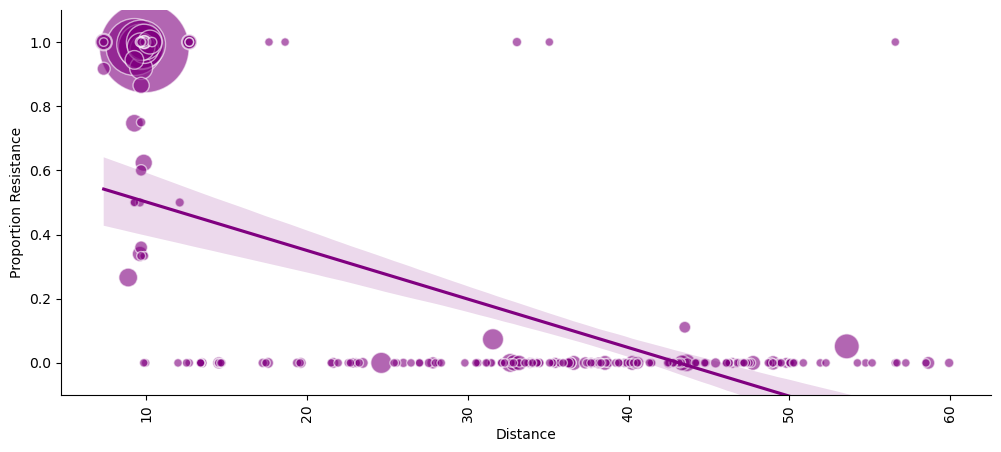

In [81]:
utils.plot_distance_vs_proportion(all_solos, data, 'Rif_distance' )

The radii of the markers represent the degree of confidence, with larger radii indicating more observed samples.

There are a few very low-frequency mutations located farther from this site that are apparently resistant. However, these are likely false positives. If the model prioritizes distance as a feature, these mutations may generate false negatives.

# Some features are more predictive than others

To get an idea of how predictive each feature is, we can train a simple single-feature logistic regression model and measure ROC AUC, recall and specificity. Because the split of the data into training/valdiation sets is non-trivial, we will train and evalulate a bunch of models and plot means with confidence limits (50 repeats).

We will also optimise for recall using scikit learns native parameter optimisation grid search, and use the default 0.5 R/S decision threshold for output probabilities.

In [82]:
outputs = {}
feature_list = data.columns[4:]
results = {feat: [] for feat in feature_list}
random_seeds = random.sample(range(1000), 50)  # Generate 50 unique random seeds

# Run the model for each feature and each seed
for seed in random_seeds:
    for feat in feature_list:
        output = Models({feat: data[[feat, 'phenotype']]}, 
                        "LR", "recall", random_seed=seed, test_fraction=0.20, 
                        verbose=False, output_plots=False).returning_output(output_plots=False)
        output["seed"] = seed
        output["feature"] = feat
        results[feat].append(output)


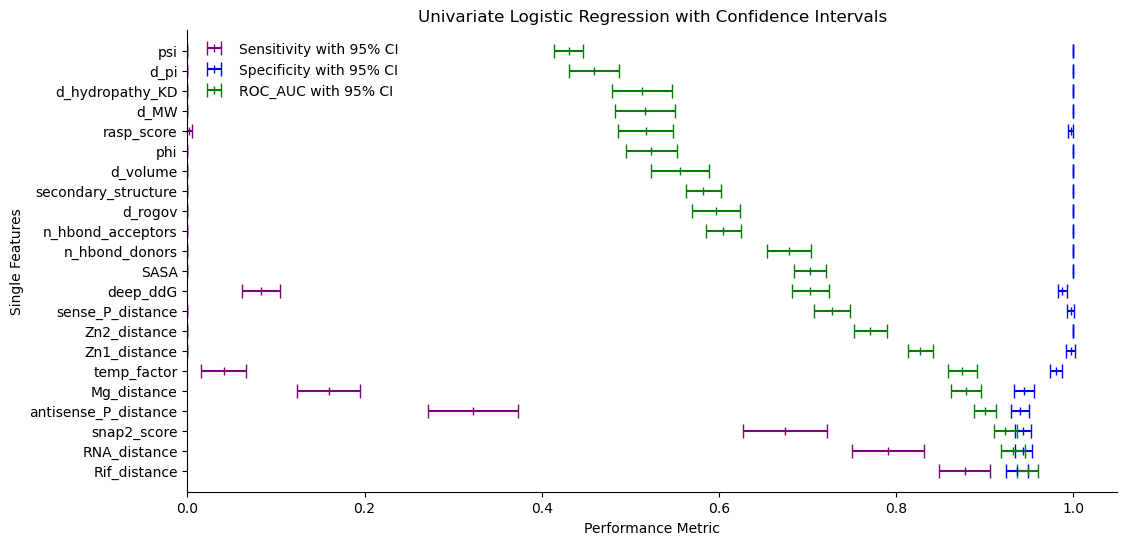

In [83]:
utils.plot_metrics_with_ci(results, feature_list, ['Sensitivity', 'Specificity', 'ROC_AUC'], sort_by='ROC_AUC', figsize=(12, 6))

Although features have varying levels of predictive power according to the ROC AUC metric, the reality is using the default post-hoc deicision threshold of 0.5 (to allow comparison across features) demonstrates zero practical predictive power for most features, as most sensitivities are zero.

Distance from RNA, snap2 score, and distance from rifampicin are the only features with any real ability to predict positive (R) test cases without applying a post hoc shifted breakpoint.

This is perhaps not entirely surprising given the clusering of RAVS around the RRDR, and the fact SNAP2 uses a neural net trained on evolutional infromation sand strucutral features (like solvent accessibility) to predict changes to secondary structure on mutation. 

Distance to rifampicin has the highest ROC AUC score - ~95% suggests discriminitive power is robust across the threshold range.

If we were to shift the deicsion threshold for lower ROC AUC features to boost recall, it would likely come the cost of false positives.

# Machine learning models trained on a few discrimatory features are predictive

As most features have little discriminatory power, we can probably just remove them with little impact on performance - we can test this via backwards elimination of features in ascending order of ROC_AUC score.

 As before, using an indepenent validation set producus large error bars as there are so few resistant mutations in the set - use Monte Carlo cross validation with 50 random splits as before.

In [84]:
roc_auc = []
for feat in results.keys():
    key_dict = dict(results[feat][0])
    roc_auc.append(key_dict["ROC_AUC"])

sorted_features = sorted(zip(feature_list, roc_auc), key=lambda x: x[1], reverse=False)

sorted_feature_list, sorted_roc_auc = zip(*sorted_features)

In [85]:
random_seeds = random.sample(range(1000), 50)  # Generate 50 unique random seeds
columns = list(sorted_feature_list) + ['phenotype']
results = {len(columns) - i - 1: [] for i in range(len(sorted_feature_list))}

# Run the model for each feature removed and each seed
for feat in sorted_feature_list:
    temp_results = []
    for seed in random_seeds:
        feature_data = data[columns]
        model = Models(
            {"all": feature_data},
            'LR',
            "recall",
            random_seed=seed,
            test_fraction=0.20,
            verbose=False,
            output_plots=False,
        )
        output = model.returning_output(output_plots=False)
        temp_results.append(output)
    results[len(columns)-1].extend(temp_results)
    columns.remove(feat)

/Users/dylanadlard/miniforge3/envs/rif_manuscript/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dylanadlard/miniforge3/envs/rif_manuscript/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

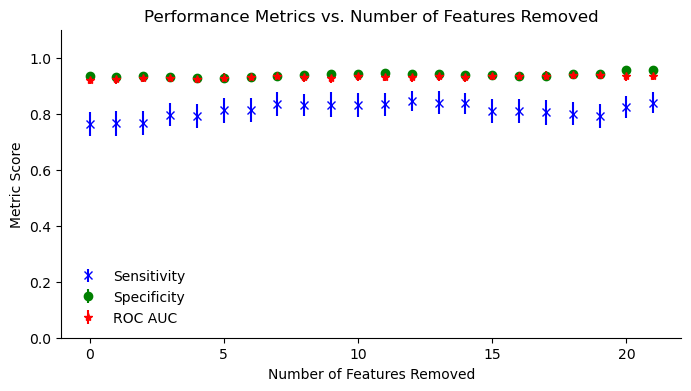

In [86]:
utils.plot_backwards_elim(results, figsize=(6, 4))

There is no significant difference between models trained with varying numbers of features. However, as long as predictive power and generalizability are retained, simpler models are preferable. We could potentially use just a single feature, Rif distance, but to maintain some variation in feature space, we can keep the top 4 features based on their individual ROC AUC scores.

In [269]:
feature_list = list(sorted_feature_list[-6:])
feature_list.remove('Mg_distance')
feature_list.remove('antisense_P_distance')

features_and_label = feature_list + ['phenotype']

print ("Features selected for:", feature_list)

Features selected for: ['temp_factor', 'snap2_score', 'RNA_distance', 'Rif_distance']


## Different model architectures

To test feature importance we have been training a logistric regression model, however other architecture may perform better:

In [210]:
random_seeds = random.sample(range(1000), 50)
model_types = ['LR', 'DT', 'RF', 'GBDT']
results = {model_type: [] for model_type in model_types}

for model_type in model_types:
    for seed in random_seeds:
        model = Models(
            {"all": data[features_and_label]},
            model_type,
            "recall",
            random_seed=seed,
            test_fraction=0.20,
            verbose=False,
            output_plots=False,
        )
        output = model.returning_output(output_plots=False)
        results[model_type].append(output)


Mean Confusion Matrix for LR:


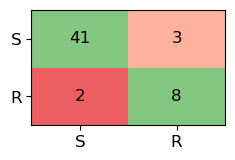

Mean Confusion Matrix for DT:


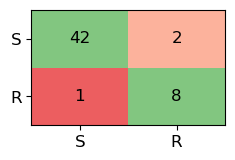

Mean Confusion Matrix for RF:


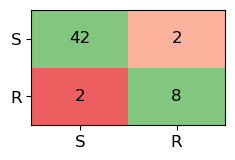

Mean Confusion Matrix for GBDT:


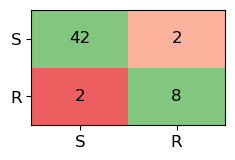

In [271]:

for model_name, model_results in results.items():
    if model_name!='ensemble':
        cm_sum = np.zeros_like(model_results[0]['Confusion_matrix_shifted'])

        # Sum the confusion matrices
        for result in model_results:
            cm_sum += result['Confusion_matrix_shifted']

        # Calculate the mean confusion matrices
        cm_mean = cm_sum / len(model_results)

        # Round to the nearest whole number
        cm_mean = np.round(cm_mean)

        # Convert confusion matrices to DataFrame for plotting
        classes = ['S', 'R']
        truth_table = pd.DataFrame(cm_mean, index=classes, columns=classes)

        # Plotting original confusion matrix
        print(f"Mean Confusion Matrix for {model_name}:")
        utils.plot_truthtables(truth_table)
        

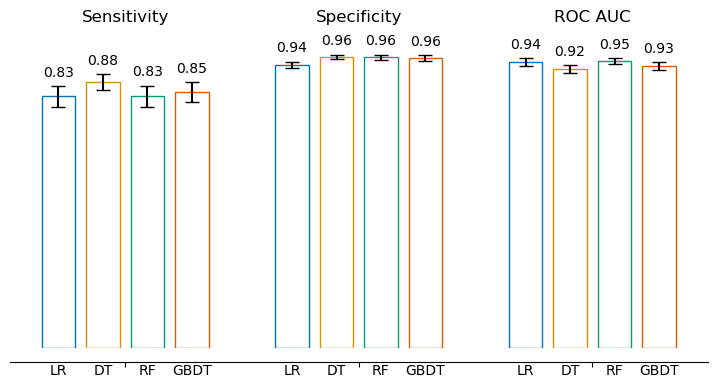

In [212]:
utils.plot_recall_specificity_with_ci(results, figsize=(9, 4))

There is no significant difference in performance among the four models, although the Decision Tree (DT) model appears to perform slightly better. However, this difference is not statistically significant, as indicated by the overlapping confidence intervals, and could vary if the analysis were rerun.

This result is intuitive, as accurate predictions can be achieved using a simple distance threshold from Rifampicin. The binary decision logic of a decision tree is particularly well-suited to this type of problem, providing heuristic-like predictions that are logical and easy to interpret (ie why over complicate).

However, it does make very major errors - lets investigate what/where those are:

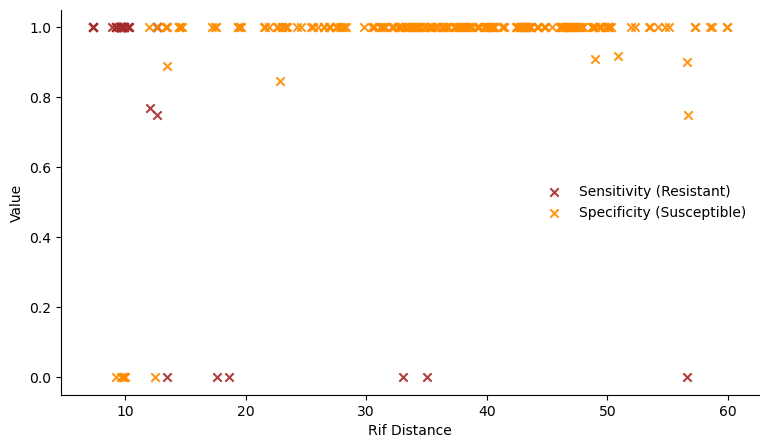

In [168]:
# Pull out optimal DT model from ml-models on random splits of the data
# and then mean the sensitivities and specificities of each mutation
# and plot with respect to distance from Rif

# Initialize dictionary for mutation stats
mutation_stats = {mut: {'FP': 0, 'FN': 0, 'TN': 0, 'TP': 0} for mut in data['mutation']}
random_seeds = random.sample(range(1000), 50)

# Iterate through random splits
for seed in random_seeds:
    model = Models(
        {"all": data[features_and_label]}, "DT", "recall",
        random_seed=seed, test_fraction=0.20,
        verbose=False, output_plots=False,
        sample_ids={'all':data.mutation}
    )

    X_train, y_train = model.X_train_nd["all"], model.y_train_nd["all"]
    X_test, y_test = model.X_test_nd["all"], model.y_test_nd["all"]
    est, thresh = model.opt_estimator, model.opt_threshold

    est.fit(X_train, y_train)
    y_pred = (est.predict_proba(X_test)[:, 1] >= thresh).astype(int)

    X_test_df = pd.DataFrame(X_test, columns=feature_list)
    X_test_df['y_test'], X_test_df['y_pred'] = y_test, y_pred

    # Identify and merge false positives/negatives with feature data to get distances
    for label, df in [('TP', (X_test_df['y_test'] == 1) & (X_test_df['y_pred'] == 1)),
                      ('TN', (X_test_df['y_test'] == 0) & (X_test_df['y_pred'] == 0)),
                      ('FP', (X_test_df['y_test'] == 0) & (X_test_df['y_pred'] == 1)),
                      ('FN', (X_test_df['y_test'] == 1) & (X_test_df['y_pred'] == 0))]:
        merged_df = pd.merge(X_test_df[df], data, on=['snap2_score', 'Rif_distance', 'RNA_distance', 'temp_factor'], how='left')
  
        for mut in merged_df['mutation']:
            mutation_stats[mut][label] += 1

# Create and plot stats DataFrame
stats_df = pd.DataFrame(mutation_stats).T.reset_index().rename(columns={'index': 'mutation'})
stats_df = pd.merge(stats_df, data[['mutation', 'Rif_distance', 'phenotype']], on='mutation', how='left')
utils.metrics_vs_distance(stats_df, figsize=(9, 5))

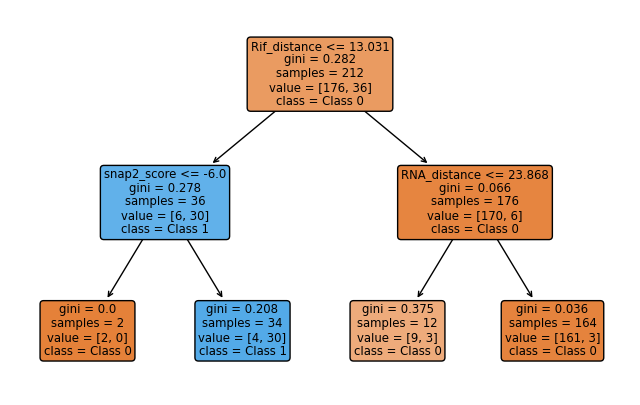

In [29]:
feature_names = [i for i in feature_list if i != 'phenotype']
plt.figure(figsize=(8, 5))
plot_tree(model.opt_estimator, feature_names=feature_list, class_names=['Class 0', 'Class 1'], filled=True, rounded=True)
plt.show()

As distance increases beyone 13A, predictions almost entirely switch to susceptible.

We get a drop in recall due to 6 mutations, which are almost certainly phenotype false positives despite passing the Binomial test's confidence threshold:

In [30]:
stats_df[stats_df.Sensitivity<0.5]

,mutation,FP,FN,TN,TP,Rif_distance,phenotype,Sensitivity,Specificity
255,E207K,0,15,0,0,35.076130,1,0.0,NaN
256,L731P,0,12,0,0,33.058292,1,0.0,NaN
258,S493R,0,8,0,0,13.468693,1,0.0,NaN
262,V262A,0,9,0,0,56.595298,1,0.0,NaN
263,S582A,0,6,0,0,18.638826,1,0.0,NaN
264,L378R,0,12,0,0,17.636419,1,0.0,NaN


# Would an ensemble model perform better?

If each model architecture is missing different RAVs, perhaps an ensemble model would work better? 

We can pull out false negatives for each model and compare:

In [323]:
model_types = ['RF', 'LR', 'DT', 'GBDT']

mutation_stats = {
    mut: {
        model: {'FP': 0, 'FN': 0, 'TN': 0, 'TP': 0}
        for model in model_types
    }
    for mut in data['mutation']
}

In [324]:
#not a priority - but we may be able to do this without re-fitting 

for i in range(50):
    for type in model_types:
        #get hyperparameter tuned model and best decision threshold
        model = Models(
        {"all": data[feature_list]}, type, "recall",
        random_seed=i, test_fraction=0.20,
        verbose=False, output_plots=False,
        sample_ids = {'all':data.mutation}
    )
        
        X_train, y_train = model.X_train_nd["all"], model.y_train_nd["all"]
        X_test, y_test = model.X_test_nd["all"], model.y_test_nd["all"]
        est, thresh = model.opt_estimator, model.opt_threshold
        #re-fit best performing model to training data
        est.fit(X_train, y_train)
        #predict on test manually so we can easily pull out TP, TN, FP, FN
        y_pred = (est.predict_proba(X_test)[:, 1] >= thresh).astype(int)

        X_test_df = pd.DataFrame(X_test, columns=data[feature_list].drop(columns=['phenotype']).columns)
        X_test_df['y_test'], X_test_df['y_pred'] = y_test, y_pred

        # Identify and merge false positives/negatives with feature data
        for label, df in [('TP', (X_test_df['y_test'] == 1) & (X_test_df['y_pred'] == 1)),
                        ('TN', (X_test_df['y_test'] == 0) & (X_test_df['y_pred'] == 0)),
                        ('FP', (X_test_df['y_test'] == 0) & (X_test_df['y_pred'] == 1)),
                        ('FN', (X_test_df['y_test'] == 1) & (X_test_df['y_pred'] == 0))]:
            
            mutations = list(model.estimator.test_ids['all'])
            for mut in mutations:
                mutation_stats[mut][type][label] += 1

In [356]:
test_equal_vals = lambda d: len(set(d.values())) > 1

sensitivity_discrepancy_dict = {}
specificity_discrepancy_dict = {}

for mutation, models in mutation_stats.items():
    sensitivity_metric = {}
    specificity_metric = {}
    
    for model, pred in models.items():
        if pred['TN'] > 0 or pred['FP'] > 0:
            specificity_metric[model] = utils.calculate_specificity(pred['TN'], pred['FP'])
        if pred['TP'] > 0 or pred['FN'] > 0:
            sensitivity_metric[model] = utils.calculate_sensitivity(pred['TP'], pred['FN'])
    
    if test_equal_vals(sensitivity_metric):
        sensitivity_discrepancy_dict[mutation] = sensitivity_metric
    
    if test_equal_vals(specificity_metric):
        specificity_discrepancy_dict[mutation] = specificity_metric


/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_51346/3190579628.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mutations, rotation=90)
/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_51346/3190579628.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mutations, rotation=90)


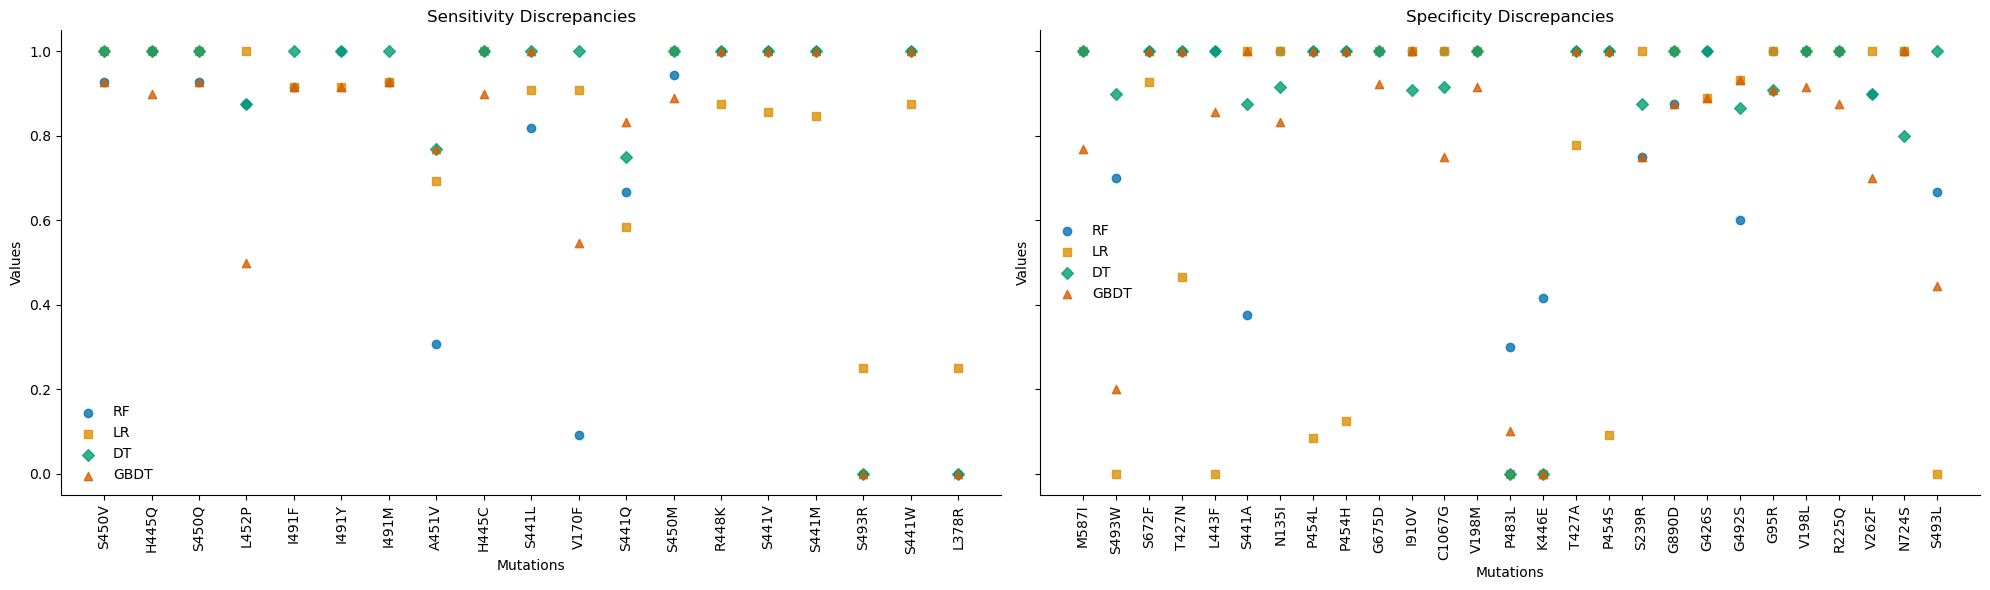

In [358]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
utils.plot_model_discrepancies(axes[0], sensitivity_discrepancy_dict, "Sensitivity Discrepancies")
utils.plot_model_discrepancies(axes[1], specificity_discrepancy_dict, "Specificity Discrepancies")
plt.tight_layout()
plt.show()

The models do not make the same predictions for all mutations (each repeat was under the same random seed across models).

Therefore, it may well be worth using an ensemble model, whereby all 4 model architectures are run and if a sinle one predict a resistnat phenotype, then a resistant phenotype is called.

In [234]:

# Sample 50 random seeds from the range 1000
random_seeds = random.sample(range(1000), 50)
model_types = ['DT', 'LR', "RF", 'GBDT']
results['ensemble']  = []

for seed in random_seeds:
    mut_predict = {}
    predict = []
    y_test_combined = []  # To store true labels for ROC AUC calculation

    for model_type in model_types:
        model = Models(
            {"all": data[features_and_label]},
            model_type,
            "recall",
            random_seed=seed,
            test_fraction=0.20,
            sample_ids={'all': data.mutation},
            verbose=False,
            output_plots=False,
        )

        X_train, y_train = model.X_train_nd["all"], model.y_train_nd["all"]
        X_test, y_test = model.X_test_nd["all"], model.y_test_nd["all"]
        est, thresh = model.opt_estimator, model.opt_threshold
        test_ids = list(model.test_ids['all'])

        est.fit(X_train, y_train)
        y_pred = (est.predict_proba(X_test)[:, 1] >= thresh).astype(int)

        X_test_df = pd.DataFrame(X_test, columns=feature_list)
        X_test_df['y_test'], X_test_df['y_pred'] = y_test, y_pred

        X_test_df['mutation'] = test_ids

        #record each models's prediction for that mutation
        for mut in X_test_df.index:
            if X_test_df['mutation'][mut] not in mut_predict.keys():
                mut_predict[X_test_df['mutation'][mut]] = [X_test_df['y_pred'][mut]]
            else:
                mut_predict[X_test_df['mutation'][mut]].append(X_test_df['y_pred'][mut])

    #heuristically aggregate each models prediction's (if a single R predicted, then predict R)
    for mutation, predictions in mut_predict.items():
        if 1 in predictions:
            predict.append(1)
        else:
            predict.append(0)

    y_test_combined.extend(y_test)  # Combine true labels

    tn, fp, fn, tp = confusion_matrix(y_test_combined, predict, labels=[0, 1]).ravel()

    sens_shifted = utils.calculate_sensitivity(tp, fn)
    spec_shifted = utils.calculate_specificity(tn, fp)
    roc_auc = roc_auc_score(y_test_combined, predict)

    results['ensemble'].append({
        'Sensitivity_shifted': sens_shifted,
        'Specificity_shifted': spec_shifted,
        'ROC_AUC': roc_auc
    })



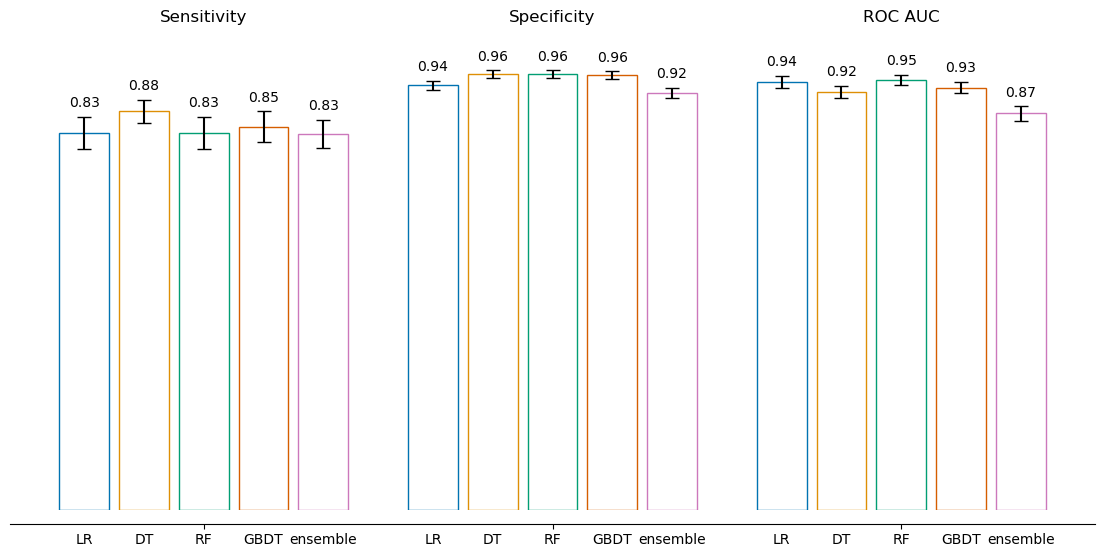

In [273]:
utils.plot_recall_specificity_with_ci(results, figsize=(14, 6))

Just logically the ensemble method should get higher recall - find out why this isn't the case before typing up!!

# Using dynamic features does not improve performance

Does replacing features pulled dowm from the static crystal structure with corresponding features pulled down from an MD simulation improve performance. For example, we could hypothesise that the minimum observed distance from a residue to rifampicin is more predictive than the arbitrary distance captured by the crystal.

In [276]:
#we need to replace features from the static structure with those from the MD simluation
static_features = data[feature_list]

def get_min_column_name(col):
    parts = col.split('_')
    if parts[0].isupper():
        return f"{parts[0]}_min_{'_'.join(parts[1:])}"
    elif len(parts) == 2:
        return f"{parts[0].capitalize()}_min_{parts[1]}"
    elif len(parts) == 3:
        return f"{parts[0]}_{parts[1]}_min_{parts[2]}"

    else:
        return f"{parts[0].capitalize()}_min_{'_'.join(parts[1:])}"

dyn_data = pd.DataFrame()

# Replace columns in static_features with corresponding min_ columns in dynamic_features
for col in static_features.columns:
    min_col = get_min_column_name(col)
    if min_col in dynamic_features.columns:
        dyn_data[min_col] = dynamic_features[min_col]
    else:
        dyn_data[col] = static_features[col]

print ('New replaced features:', list(dyn_data.columns))

New replaced features: ['temp_factor', 'snap2_score', 'RNA_min_distance', 'Rif_min_distance']


Train on both static and dynamic features and compare performance, under the same Monte Carlo splits:


In [204]:
dyn_data['phenotype'] = data['phenotype']
random_seeds = random.sample(range(1000), 50)
results = {'static': [], 'dynamic': []}

for seed in random_seeds:
    # Train on data[feature_list]
    model_data = Models(
        {"all": data[features_and_label]},
        'DT',
        "recall",
        random_seed=seed,
        test_fraction=0.20,
        verbose=False,
        output_plots=False,
    )
    output_data = model_data.returning_output(output_plots=False)
    results['static'].append(output_data)

    # Train on dyn_data
    model_dyn = Models(
        {"all": dyn_data},
        "DT",
        "recall",
        random_seed=seed,
        test_fraction=0.20,
        verbose=False,
        output_plots=False,
    )
    output_dyn = model_dyn.returning_output(output_plots=False)
    results['dynamic'].append(output_dyn)

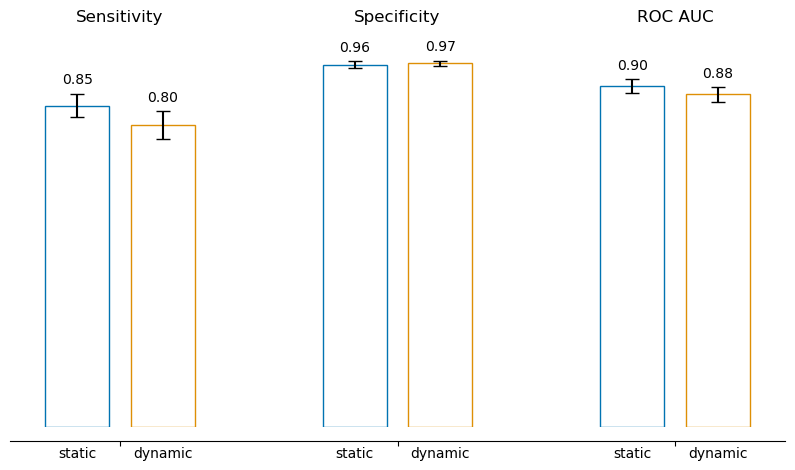

In [205]:
utils.plot_recall_specificity_with_ci(results, figsize=(10, 5))

Replacing the static features with dynamic features makes pretty much no difference (actually looks a bit worse), which perhaps isn't very surprising as the difference in distances is small.

# Can we predict phenotyps for all possible 1-snp point mutations in rpoB?

In [ ]:
aminoacids = "FFLLSSSSYY!!CC!WLLLLPPPPHHQQRRRRIIIMTTTTNNKKSSRRVVVVAAAADDEEGGGG"
bases = ["t", "c", "a", "g"]
all_codons = np.array([a + b + c for a in bases for b in bases for c in bases])
codon_to_amino_acid = dict(zip(all_codons, aminoacids))

# Function to translate nucleotide sequence to amino acid sequence
def translate_sequence(nucleotide_seq):
    # Ensure nucleotide_seq is a string
    nucleotide_seq = ''.join(nucleotide_seq)
    codons = [nucleotide_seq[i:i+3] for i in range(0, len(nucleotide_seq), 3)]
    aa_seq = ''.join([codon_to_amino_acid.get(codon, 'X') for codon in codons])
    return aa_seq

#instantiate gumpy object
gene_name = "rpoB"
genbank_file = "./data/genetic/NC_000962.gbk"
genome = gumpy.Genome(genbank_file)
gene = genome.build_gene(gene_name)

#create wt nucleotide and aa sequences
original_nucleotide_seq = ''.join(gene.codons)
original_nucleotide_seq = 'a' + original_nucleotide_seq[1:] #gumpy gets the first nucleotide wrong for some reason
original_aa_seq = translate_sequence(original_nucleotide_seq)
mutations = []

# Iterate over each nucleotide position and generate mutants
for i, original_base in enumerate(original_nucleotide_seq):
    for new_base in "tcag":
        if new_base != original_base:
            mutated_nucleotide_seq = [i for i in original_nucleotide_seq]
            mutated_nucleotide_seq[i] = new_base
            mutant_aa_seq = translate_sequence(mutated_nucleotide_seq)

            if mutant_aa_seq != original_aa_seq:
                original_codon_index = i // 3
                original_aa = original_aa_seq[original_codon_index]
                mutated_aa = mutant_aa_seq[original_codon_index]
                
                if mutated_aa != original_aa and mutated_aa != "!":
                    mutation_format = f"{original_aa}{original_codon_index + 1}{mutated_aa}"
                    mutations.append(mutation_format)

mutations = list(set(mutations))

print ('\nTotal number of point mutations that can be generated from a single nucleotide snp:', len(mutations))

/Users/dylanadlard/miniforge3/envs/rif_manuscript/lib/python3.12/site-packages/Bio/SeqFeature.py:230: BiopythonDeprecationWarning: Please use .location.strand rather than .strand
  warnings.warn(



Total number of point mutations that can be generated from a single nucleotide snp: 6970


We need to build a feature set for these mutations:

In [ ]:
scan_df = pd.DataFrame(mutations, columns=['mutation'])
scan_df['resid'] = [int(i[1:-1]) for i in scan_df.mutation]
scan_df['segid'] = 'C'

#filter out residues attenuated from pdf file
scan_df = scan_df[(scan_df['resid']>=22) & (scan_df ['resid']<=1147)]

scan_df = utils.generate_feature_set(scan_df)


/Users/dylanadlard/miniforge3/envs/rif_manuscript/lib/python3.12/site-packages/sbmlcore/ExternalCode.py:313: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  snap2_df['Expected Accuracy'].replace(to_replace='%', value='', regex=True, inplace=True)


We can train our model on the entire training set (of solos) to maximise training data.

We will also use the ensemble model to maximise sensitivity, so even low confidence RAVs are flagged.

In [ ]:
model_types = ['DT', 'LR', "RF", 'GBDT']
outputs = {}

mut_predict = {}
y = []

# Loop over each model type
for model_type in model_types:
    feature_list.append('phenotype')
    
    model = Models(
        {"all": data[feature_list]},
        model_type,
        "recall",
        random_seed=seed,
        test_fraction=0.1,
        sample_ids={'all': data.mutation},
        verbose=False,
        output_plots=False,
    )

    X_train, y_train = model.X_train_nd["all"], model.y_train_nd["all"]
    est, thresh = model.opt_estimator, model.opt_threshold

    # Retrain the model on the entire training data
    est.fit(X_train, y_train)

    # Prepare the scan_df feature set
    feature_list.remove('phenotype')
    X_scan = scan_df[feature_list]

    # Predict phenotypes for the scan_df feature set
    scan_predictions = (est.predict_proba(X_scan)[:, 1] >= thresh).astype(int)

    # Update mut_predict with the scan predictions
    for idx, mut in enumerate(scan_df['mutation']):
        if mut not in mut_predict:
            mut_predict[mut] = [scan_predictions[idx]]
        else:
            mut_predict[mut].append(scan_predictions[idx])

# Determine the final phenotype predictions
y = [1 if 1 in preds else 0 for preds in mut_predict.values()]

# Assign the predictions back to the scan_df
scan_df['phenotype'] = y


/Users/dylanadlard/miniforge3/envs/rif_manuscript/lib/python3.12/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/dylanadlard/miniforge3/envs/rif_manuscript/lib/python3.12/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/dylanadlard/miniforge3/envs/rif_manuscript/lib/python3.12/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/dylanadlard/miniforge3/envs/rif_manuscript/lib/python3.12/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [ ]:
#now map these phenotypes onto a structure of RNAP
utils.map_mut2pdb(scan_df, './data/pdb/5uh6.pdb', './data/pdb/mutate_every_pos.pdb', phenotypes=True)

/Users/dylanadlard/miniforge3/envs/rif_manuscript/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
/Users/dylanadlard/miniforge3/envs/rif_manuscript/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [ ]:
scan_df.phenotype.value_counts()

phenotype
0    6244
1     443
Name: count, dtype: int64

# Can we validate on external samples - theres something here, just go back and check last few cells of methods.ipynb and reconsider filtering steps below - if we keep samples with susceptible rows in the training data we might have enough R samples to validate

The dataset on which the model is trained was generated by looking for solos across the rpoB gene. Therefore samples with more than 1 mutation were discarded, which leaves a potentially large pool of samples we can validate our model on.

However, the model only predicts the effect of a mutation in isolation. But we can predict phenotyupes for each mutation in turn, and then use a heuristic to decide the final phenotype.

If a sample contains at least one mutation predicted resistant, then a resistant phenotype is called.

In [247]:
#load in catalogue used to generate training set and pull out sample ids
catalogue = pd.read_csv('./data/tables/generated/catalogue.csv', index_col=0)
catalogue['EVIDENCE'] = catalogue['EVIDENCE'].apply(utils.str_to_dict)

ids = []
for i in catalogue.EVIDENCE:
    if 'seeded' not in i and len(i)>0 and 'ids' in i[0] :
        ids += i[0]['ids']

#read in all samples and their mutations
all_matched = pd.read_csv('./data/tables/generated/all_matched.csv', index_col=0, low_memory=False)
#remove ids used in the training set from the wider dataset
ext_val = all_matched[~all_matched.UNIQUEID.isin(ids)]
#drop rpoB WT rows, as a bit pointless validating them
ext_val.dropna(subset='MUTATION', inplace=True)
#drop samples containing promoter mutations, indels, or premature stops as our model can't handle these
samples_to_drop = ext_val[ext_val['MUTATION'].str.contains(r'_|\!|\*|-')].UNIQUEID.unique()
ext_val = ext_val[~ext_val.UNIQUEID.isin(samples_to_drop)]

#also have to drop samples contianing mutations outside the pdb region
ext_val['resid'] = [int(i[1:-1]) for i in ext_val.MUTATION]
ext_val = ext_val[(ext_val['resid']>=22) & (ext_val['resid']<=1147)]

ext_val = ext_val[['UNIQUEID', 'PHENOTYPE', 'MUTATION']].rename(columns={'PHENOTYPE':'phenotype', 'MUTATION':'mutation'})
ext_val



/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_51346/2476610271.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ext_val.dropna(subset='MUTATION', inplace=True)


,UNIQUEID,phenotype,mutation
8,site.01.subj.DR0613.lab.DR0613.iso.1,R,T400A
9,site.01.subj.DR0613.lab.DR0613.iso.1,R,S450L
16,site.01.subj.DR0031.lab.DR0031.iso.1,R,S450L
17,site.01.subj.DR0031.lab.DR0031.iso.1,R,R552C
26,site.01.subj.DR0701.lab.DR0701.iso.1,R,S450L
...,...,...,...
36416,site.07.subj.CEF46D15-8E0D-4114-9B5D-92E1CB475...,R,H835R
36778,site.07.subj.FD_127_2698.lab.15_0601041.iso.1,S,D435Y
36779,site.07.subj.FD_127_2698.lab.15_0601041.iso.1,S,N437D
37101,site.07.subj.1EBDBB4E-4189-43DC-BBEE-3F908EAEC...,R,S450L


In [248]:
#pull out unique mutations and run them through sbmlcore to generate validation feature set
val_muts = ext_val.drop_duplicates('mutation', keep='first')[['mutation']]
val_muts['resid'] = [i[1:-1] for i in val_muts.mutation]
val_muts['segid'] = 'C'
#generate feature set - this uses the exact same code as described in methods.ipynb (saving space)    
val_muts = utils.generate_feature_set(val_muts)

/Users/dylanadlard/miniforge3/envs/rif_manuscript/lib/python3.12/site-packages/sbmlcore/ExternalCode.py:313: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  snap2_df['Expected Accuracy'].replace(to_replace='%', value='', regex=True, inplace=True)


,segid,resid,mutation,d_volume,d_hydropathy_KD,d_MW,d_pi,d_rogov,Rif_distance,Mg_distance,...,temp_factor,Rif_min_distance,Mg_min_distance,Zn1_min_distance,Zn2_min_distance,antisense_P_min_distance,RNA_min_distance,mean_phi,mean_psi,secondary_structure
0,C,400,T400A,-27.5,2.5,-30.0,0.40,0.248,47.277753,67.847655,...,86.720001,45.207705,66.687726,80.914137,43.660462,47.301019,59.315231,-102.270270,5.365811,0
1,C,450,S450L,77.7,4.6,26.1,0.30,0.015,9.880496,26.846155,...,14.380000,9.498353,26.483208,54.622316,59.606831,18.179579,20.826102,-139.700114,145.935434,1
2,C,552,R552C,-64.9,7.0,-53.0,-5.69,-0.392,46.176173,47.690675,...,96.110001,41.401189,39.060666,68.279127,96.372134,47.108089,41.116181,-137.700124,149.323828,2
3,C,827,R827L,-6.7,8.3,-43.0,-4.78,-0.090,40.457681,46.780536,...,66.910004,36.625523,44.934909,59.397987,21.368434,41.423416,40.001865,-117.391004,151.482875,1
4,C,435,D435V,28.9,7.7,-16.0,3.19,-0.182,9.263286,24.022115,...,14.750000,6.468814,22.288308,59.593582,55.415774,25.099054,16.643368,-69.581912,114.653556,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,C,979,L979R,6.7,-8.3,43.0,4.78,-0.090,40.549583,33.321165,...,45.700001,36.005327,28.494424,70.322672,89.819941,50.060919,31.924005,-68.167306,-40.690809,0
320,C,681,C681R,64.9,-7.0,53.0,5.69,-0.392,31.238999,37.930574,...,25.670000,26.421523,36.300779,78.675452,66.373975,47.310230,33.344084,-136.569896,140.483895,1
321,C,531,D531E,27.3,0.0,14.0,0.45,0.109,33.458970,42.280109,...,58.799999,31.863112,39.517160,62.873936,81.592839,34.077173,37.881510,-59.092749,-23.840369,0
322,C,435,D435F,78.8,6.3,32.1,2.71,-0.227,9.263286,24.022115,...,14.750000,6.468814,22.288308,59.593582,55.415774,25.099054,16.643368,-69.581912,114.653556,3


In [251]:
#use ml-models to determine the best model and threshold on the training set
feature_list.append('phenotype')
opt_model = Models(
        {"all": data[feature_list]},
        'DT',
        "recall",
        random_seed=seed,
        test_fraction=0.1,
        verbose=False,
        output_plots=False,
    )

model = opt_model.opt_estimator
threshold = opt_model.opt_threshold

X = data[feature_list].drop(columns=['phenotype'])
y = data['phenotype']
#retrain the model on the entire training set (ml-models does a mandatory data split, which we need to hack around)
model = model.fit(X, y)

#predict effect on rifampicin resistance for each unique mutation in the validation set
columns = [i for i in feature_list if i != 'phenotype']
predictions = model.predict(val_muts[columns])

val_muts['mut_prediction'] = predictions

#merge sample validation set and mutation validation set
ext_val = pd.merge(ext_val, val_muts, on='mutation', how='left')
ext_val


In [277]:
label, y = [], []

ids = ext_val.UNIQUEID.unique()
for id in ids:
    sample = ext_val[ext_val.UNIQUEID == id]
    label.append(1 if sample['phenotype'].iloc[0] == 'R' else 0)
    y.append(1 if 1 in sample['mut_prediction'].values else 0)

tn, fp, fn, tp = confusion_matrix(label, y).ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)


In [278]:
sensitivity

0.998551774076756

In [279]:
print ('Sensitivity:', sensitivity)
print ('Specificity:', specificity)

Sensitivity: 0.998551774076756
Specificity: 0.0


 The reason we basically have no ssuceptible samples in our validation set is becuase we've used most susceptible samples in the catalogue - the one tailed test captures everything:

In [293]:
print ('Fraction of samples in our validation set that are susceptible:\n',  ext_val.drop_duplicates(['UNIQUEID'], keep='first')['phenotype'].value_counts())

Fraction of samples in our validation set that are susceptible:
 phenotype
R    1381
S      36
Name: count, dtype: int64


Therefore, can only really report sensitivity.

How many of these samples contain resistant mutations in the training set, though?

In [289]:
remove = []
for id in ids:
    samples = ext_val[ext_val.UNIQUEID==id]
    if samples.mutation.isin(data[data.phenotype==1].mutation).any():
        remove.append(id)

print ('Fraction of samples that contain resistant mutations in the training set', len(remove)/ext_val.UNIQUEID.nunique())

Fraction of samples that contain resistant mutations in the training set 0.9978828510938603


Basically all validation samples overlap with the training set, which means we can't do a fair evaluation. Although we have samples that weren't captured by the training set, they all contain resistant mutations that were.

However, it also means our training set has captured pretty well all observed variability in the datatset and no RAVs (or susceptible mutations) are missed by the training set generation step - which is good (of course this only applies to samples with point mutations in the coding region).